
# Machine Learning for Corrosion Parameter Optimization

This notebook implements a machine learning-driven approach to optimize two critical corrosion parameters, `Ecorr_V_vs_SCE` (corrosion potential) and `Icorr_uAcm2` (corrosion current density), based on experimental input conditions: `CurrentDensity_mAcm2` and `TreatmentTime_sec`.

## 1. Project Goal

The primary objective is to find the optimal combination of `CurrentDensity_mAcm2` and `TreatmentTime_sec` that simultaneously:
*   **Maximizes `Ecorr_V_vs_SCE`** such that it remains negative (i.e., makes it less negative, closer to zero).
*   **Minimizes `Icorr_uAcm2`** such that it remains positive (i.e., makes it as small as possible).
*   **Maintains `TreatmentTime_sec`** within a specific range: **100 to 300 seconds**.

This is a multi-objective optimization problem with specific constraints.

## 2. Methodology: Surrogate Modeling with Global Optimization

Given the nature of the problem (finding optimal inputs for complex outputs) and potentially a small dataset (common in experimental work), a common and effective approach is **surrogate modeling combined with global optimization**.

### 2.1. Data Preparation and Preprocessing

Before building any models, the raw data needs to be cleaned and prepared:
*   **Data Loading**: The `PEO_data.csv` file is loaded using `pandas`. Special attention was paid to ensure correct file path, encoding (`utf-8` was used, but `latin1` or `cp1252` could be tried if encoding errors persist), and exact column name matching.
*   **Feature-Target Split**:
    *   **Features (Inputs, `X`)**: `CurrentDensity_mAcm2`, `TreatmentTime_sec`
    *   **Targets (Outputs, `y`)**: `Ecorr_V_vs_SCE`, `Icorr_uAcm2`
*   **Train-Test Split**: The dataset is divided into training (80%) and testing (20%) subsets. The training set is used to build the predictive models, while the test set is reserved to evaluate their generalization performance on unseen data.
*   **Feature Scaling (`StandardScaler`)**: Input features (`CurrentDensity_mAcm2` and `TreatmentTime_sec`) are scaled to have a mean of 0 and a standard deviation of 1. This is crucial for algorithms like Support Vector Regression (SVR) as it prevents features with larger numerical ranges from disproportionately influencing the model.

### 2.2. Surrogate Models: Support Vector Regression (SVR)

Instead of directly optimizing the experimental process, we first build fast-to-evaluate predictive models (surrogates) based on the existing data.
*   **Model Choice**: **Support Vector Regression (SVR)** was chosen. SVR is well-suited for regression tasks, can model complex non-linear relationships using kernels (here, the Radial Basis Function 'rbf' kernel), and often performs robustly even with smaller datasets.
*   **Multi-Output Handling**: Since SVR is inherently a single-output model, two separate SVR models are trained:
    1.  One SVR model to predict `Ecorr_V_vs_SCE` from `CurrentDensity_mAcm2` and `TreatmentTime_sec`.
    2.  Another SVR model to predict `Icorr_uAcm2` from the same inputs.
*   **Hyperparameter Tuning (`GridSearchCV`)**: The performance of SVR is highly dependent on its hyperparameters, particularly `C` (regularization) and `gamma` (kernel coefficient). `GridSearchCV` is used to systematically search for the optimal combination of these hyperparameters. It employs **5-fold cross-validation** on the training data to ensure the selected hyperparameters lead to models that generalize well and are not overfit to a single data split.

### 2.3. Objective Function Formulation

The core of the optimization is the `objective_function`. This custom Python function translates the desired optimization goals and constraints into a single scalar value that a minimization algorithm can interpret.
*   **Inputs**: It takes `CurrentDensity_mAcm2` and `TreatmentTime_sec` as candidate input parameters.
*   **Prediction**: It uses the previously trained SVR surrogate models to predict the corresponding `Ecorr_V_vs_SCE` and `Icorr_uAcm2` values for these inputs.
*   **Goals as Minimization**:
    *   **Maximize `Ecorr_V_vs_SCE` (negative)**: This is converted into minimizing `-Ecorr_V_vs_SCE`. A less negative `E_corr` results in a smaller (more favorable) value for `-E_corr`.
    *   **Minimize `Icorr_uAcm2` (positive)**: This directly corresponds to minimizing `Icorr_uAcm2`.
*   **Weighted Sum**: The two objective components are combined into a single value using `optimization_weights`. These weights are crucial for balancing the trade-off between the potentially conflicting objectives. (e.g., `Icorr_uAcm2` often has much smaller values, so a larger weight is applied to ensure its minimization contributes significantly to the overall objective).
*   **Penalty Terms**: To enforce the "soft" constraints (`Ecorr_V_vs_SCE` must be negative, `Icorr_uAcm2` must be positive), a large penalty is added to the objective value if a predicted outcome violates these conditions. This strongly discourages the optimizer from selecting input combinations that lead to undesirable or unphysical results.

### 2.4. Optimization Algorithm: Differential Evolution

Once the predictive models are trained and the objective function is defined, a global optimization algorithm is employed to find the best input parameters.
*   **Algorithm Choice**: **Differential Evolution (`scipy.optimize.differential_evolution`)** is a robust and powerful global optimization algorithm. It is particularly well-suited for complex, non-linear objective functions (like our SVR-based one) and can effectively search large parameter spaces to find global optima, rather than getting stuck in local minima.
*   **Hard Constraints (`bounds`)**: The strict constraint on `TreatmentTime_sec` (100 to 300 seconds) and the range for `CurrentDensity_mAcm2` (derived from the training data) are enforced directly using the `bounds` parameter of the `differential_evolution` function. This ensures the optimizer only explores physically relevant and allowed input conditions.
*   **Process**: The algorithm iteratively generates and refines a "population" of candidate solutions, evaluating each using the `objective_function`, until it converges on a set of input parameters that minimize the objective.

## 3. Interpretation of Results

The final output provides the `Optimal Current Density`, `Optimal Treatment Time`, and the `Predicted E_corr` and `Predicted i_corr` at these optimal conditions. This information represents the recommended input settings derived from the machine learning models that best satisfy your multi-objective optimization criteria and constraints. Checks are also performed to verify that the predicted optimal values adhere to the specified constraints (negative `E_corr`, positive `i_corr`, and `time` within range).

---

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.optimize import differential_evolution
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns # For enhanced visualizations

# Suppress ConvergenceWarning from SVR if it doesn't converge perfectly
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

csv_file_path = '/home/shahmir/Desktop/Erfan/PEO_data.csv'

file_encoding = 'utf-8'

print(f"Current working directory: {os.getcwd()}")
print(f"Attempting to load file: {os.path.abspath(csv_file_path)} with encoding '{file_encoding}'")

df = None
try:
    df = pd.read_csv(csv_file_path, encoding=file_encoding)
    print(f"\nSuccessfully loaded data from '{csv_file_path}' with {len(df)} rows and {len(df.columns)} columns.")
    print("Columns in your CSV as read by pandas:", df.columns.tolist())

    required_columns = ['CurrentDensity_mAcm2', 'TreatmentTime_sec', 'Ecorr_V_vs_SCE', 'Icorr_uAcm2']

    if not all(col in df.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in df.columns]
        raise ValueError(f"CSV must contain the following columns (case-sensitive): {required_columns}. Missing: {missing_cols}. Found: {df.columns.tolist()}")

except FileNotFoundError:
    print(f"\nCRITICAL ERROR: The file '{csv_file_path}' was not found.")
    print("Please double-check the file name and path.")
    exit()
except ValueError as e:
    print(f"\nCRITICAL ERROR in data processing: {e}")
    print("Please ensure your CSV has the *exact* required column names (case-sensitive).")
    exit()
except Exception as e:
    print(f"\nCRITICAL ERROR: An unexpected error occurred while loading or processing the CSV: {e}")
    print(f"This might be an encoding issue. Try changing `file_encoding` from '{file_encoding}' to 'latin1' or 'cp1252'.")
    exit()

# --- 2. Data Preprocessing ---
X = df[['CurrentDensity_mAcm2', 'TreatmentTime_sec']]
y_E_corr = df['Ecorr_V_vs_SCE']
y_i_corr = df['Icorr_uAcm2']

X_train, X_test, y_E_corr_train, y_E_corr_test, y_i_corr_train, y_i_corr_test = \
    train_test_split(X, y_E_corr, y_i_corr, test_size=0.2, random_state=42)

X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
print("\nFeatures scaled successfully.")

# --- 3. SVR Model Training with Hyperparameter Tuning ---
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

print("\nTraining SVR for E_corr with GridSearchCV...")
svr_E_corr = SVR()
grid_search_E_corr = GridSearchCV(svr_E_corr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search_E_corr.fit(X_train_scaled, y_E_corr_train)
best_svr_E_corr = grid_search_E_corr.best_estimator_
print(f"Best SVR for E_corr parameters: {grid_search_E_corr.best_params_}")
print(f"SVR E_corr R2 on test set: {best_svr_E_corr.score(X_test_scaled, y_E_corr_test):.4f}")

print("\nTraining SVR for i_corr with GridSearchCV...")
svr_i_corr = SVR()
grid_search_i_corr = GridSearchCV(svr_i_corr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search_i_corr.fit(X_train_scaled, y_i_corr_train)
best_svr_i_corr = grid_search_i_corr.best_estimator_
print(f"Best SVR for i_corr parameters: {grid_search_i_corr.best_params_}")
print(f"SVR i_corr R2 on test set: {best_svr_i_corr.score(X_test_scaled, y_i_corr_test):.4f}")

# --- Global variable to store convergence history ---
convergence_history = []

# --- 4. Define the Objective Function for Optimization ---
# This function's signature must match how it's called by differential_evolution.
# The 'weights' argument will be passed through 'args' of differential_evolution.
def objective_function(params, svr_E_corr_model, svr_i_corr_model, scaler, current_weights):
    current_density_unscaled, time_unscaled = params[0], params[1]
    params_scaled = scaler.transform([[current_density_unscaled, time_unscaled]])
    predicted_E_corr = svr_E_corr_model.predict(params_scaled)[0]
    predicted_i_corr = svr_i_corr_model.predict(params_scaled)[0]

    objective_val = 0
    penalty = 0.0

    if predicted_E_corr >= 0:
        penalty += 1000.0 * (predicted_E_corr + 0.1)

    if predicted_i_corr <= 0:
        penalty += 1000.0 * abs(predicted_i_corr - 0.0001)

    objective_val += current_weights['i_corr'] * predicted_i_corr
    objective_val += current_weights['E_corr'] * (-predicted_E_corr)

    return objective_val + penalty

# --- Callback function for differential_evolution to log progress ---
# This signature must match scipy's expectation: callback(xk, convergence)
def callback_function(xk, convergence=None):
    global convergence_history
    # Access the required variables from the global scope for objective_function
    global objective_function, best_svr_E_corr, best_svr_i_corr, X_scaler, optimization_weights

    # Calculate the objective value using the current best solution xk
    # We use 'optimization_weights' (the global one for the main run)
    current_objective_value = objective_function(
        xk,
        best_svr_E_corr,
        best_svr_i_corr,
        X_scaler,
        optimization_weights # Use the global optimization_weights for the main run's history
    )
    iteration = len(convergence_history) + 1 # Simple iteration count
    convergence_history.append((iteration, current_objective_value))
    # print(f"Iteration {iteration}: Best Objective = {current_objective_value:.4f}") # Uncomment for verbose callback

# --- 5. Optimization using Differential Evolution ---
# Define the specific weights for the main optimization run
optimization_weights = {
    'i_corr': 10000.0,
    'E_corr': 1.0
}

min_cd, max_cd = df['CurrentDensity_mAcm2'].min(), df['CurrentDensity_mAcm2'].max()
bounds = [
    (min_cd, max_cd),
    (100, 300)
]

print(f"\nOptimization bounds for CurrentDensity_mAcm2: {bounds[0]}")
print(f"Optimization bounds for TreatmentTime_sec (user constraint): {bounds[1]}")

# Reset convergence history before the main run
convergence_history = []
# Pass the objective_function's fixed arguments via 'args'
result = differential_evolution(
    objective_function,
    bounds,
    args=(best_svr_E_corr, best_svr_i_corr, X_scaler, optimization_weights),
    strategy='best1bin',
    maxiter=1000,
    popsize=15,
    tol=0.01,
    seed=42,
    disp=True,
    callback=callback_function # Add the corrected callback
)

# --- 6. Interpret Results ---
optimal_current_density = result.x[0]
optimal_time = result.x[1]

optimal_params_scaled = X_scaler.transform([[optimal_current_density, optimal_time]])
predicted_optimal_E_corr = best_svr_E_corr.predict(optimal_params_scaled)[0]
predicted_optimal_i_corr = best_svr_i_corr.predict(optimal_params_scaled)[0]

print("\n--- Optimization Results ---")
print(f"Optimal Current Density (mA/cm^2): {optimal_current_density:.4f}")
print(f"Optimal Treatment Time (sec): {optimal_time:.4f}")
print(f"Predicted E_corr (V vs SCE) at optimal conditions: {predicted_optimal_E_corr:.4f}")
print(f"Predicted i_corr (uA/cm^2) at optimal conditions: {predicted_optimal_i_corr:.6f}")
print(f"Optimal Objective Value: {result.fun:.4f}")

print("\n--- Constraint and Objective Check at Optimal Point ---")
print(f"Is predicted E_corr negative? {predicted_optimal_E_corr < 0} (Value: {predicted_optimal_E_corr:.4f})")
print(f"Is predicted i_corr positive? {predicted_optimal_i_corr > 0} (Value: {predicted_optimal_i_corr:.6f})")
print(f"Is optimal time between 100 and 300? {100 <= optimal_time <= 300} (Value: {optimal_time:.4f})")




Current working directory: /home/shahmir/Desktop/Erfan
Attempting to load file: /home/shahmir/Desktop/Erfan/PEO_data.csv with encoding 'utf-8'

Successfully loaded data from '/home/shahmir/Desktop/Erfan/PEO_data.csv' with 12 rows and 4 columns.
Columns in your CSV as read by pandas: ['CurrentDensity_mAcm2', 'TreatmentTime_sec', 'Ecorr_V_vs_SCE', 'Icorr_uAcm2']

Features scaled successfully.

Training SVR for E_corr with GridSearchCV...
Best SVR for E_corr parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
SVR E_corr R2 on test set: -0.4821

Training SVR for i_corr with GridSearchCV...
Best SVR for i_corr parameters: {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
SVR i_corr R2 on test set: 0.5836

Optimization bounds for CurrentDensity_mAcm2: (np.int64(2000), np.int64(2400))
Optimization bounds for TreatmentTime_sec (user constraint): (100, 300)
differential_evolution step 1: f(x)= 6348.113847238354
differential_evolution step 2: f(x)= 5529.781677044555
differential_evolution step 3:


             GENERATING ALL PLOTS              



<Figure size 1200x1000 with 0 Axes>

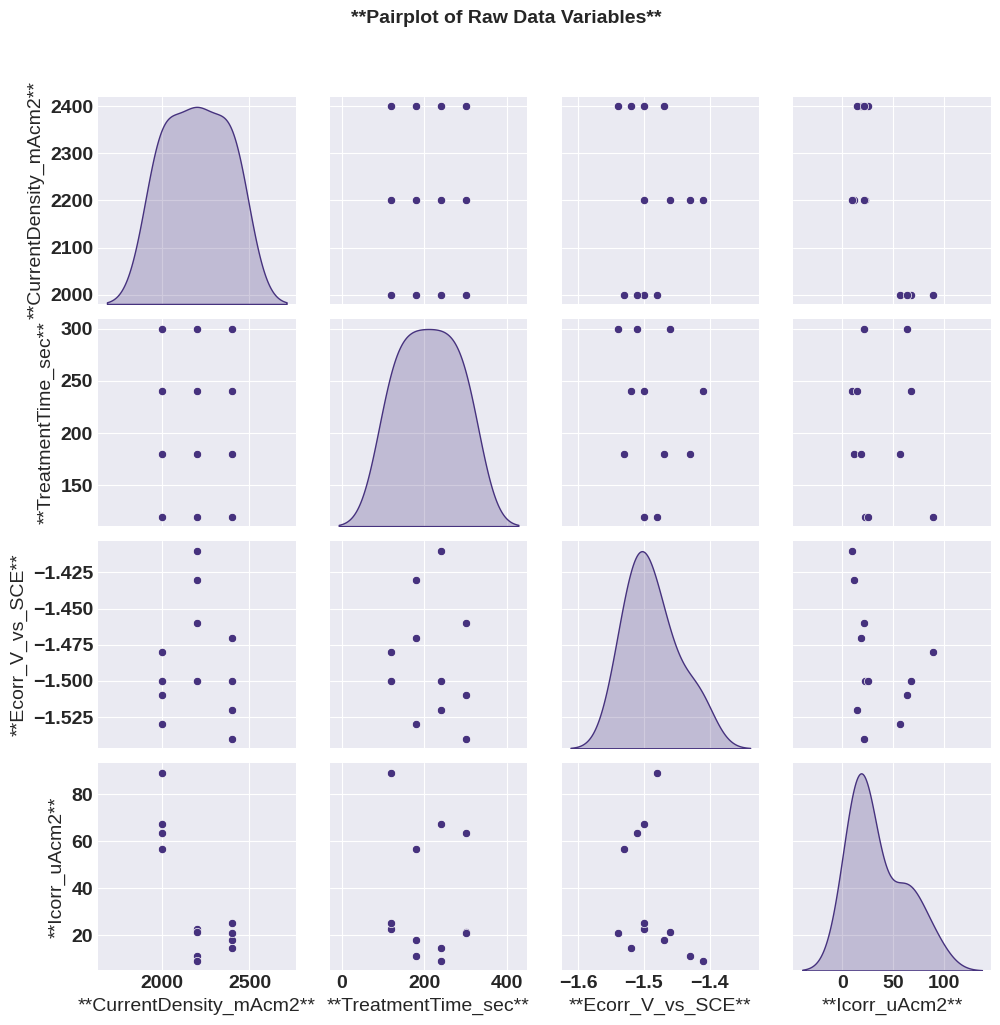

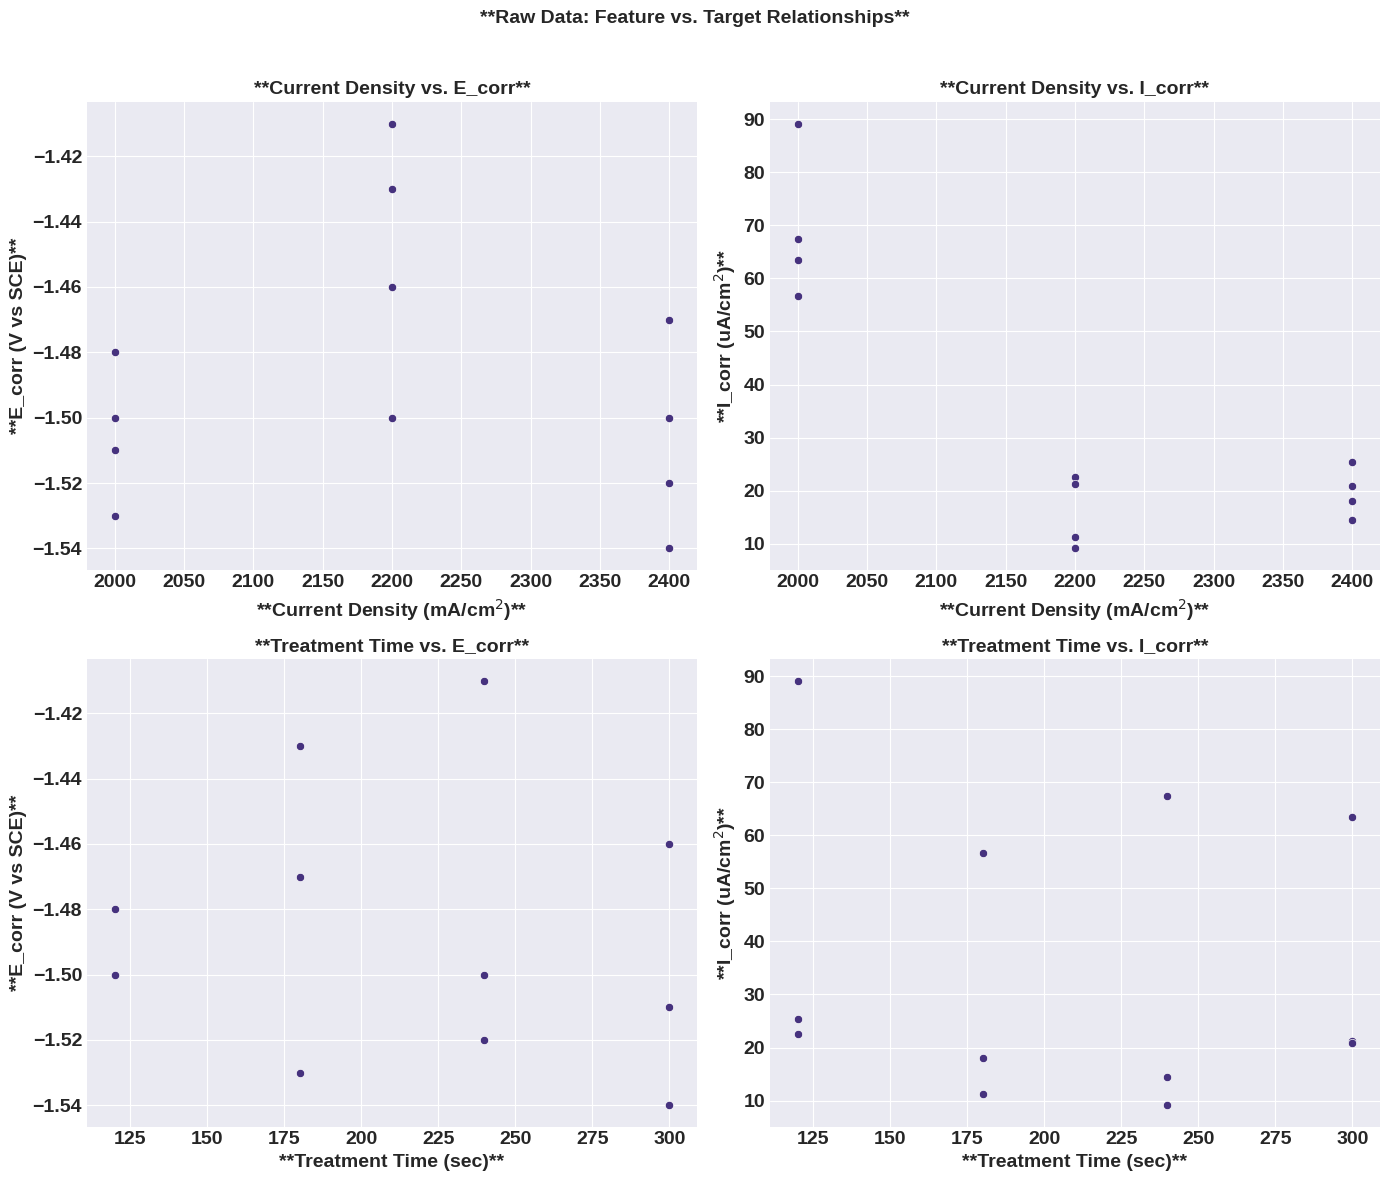

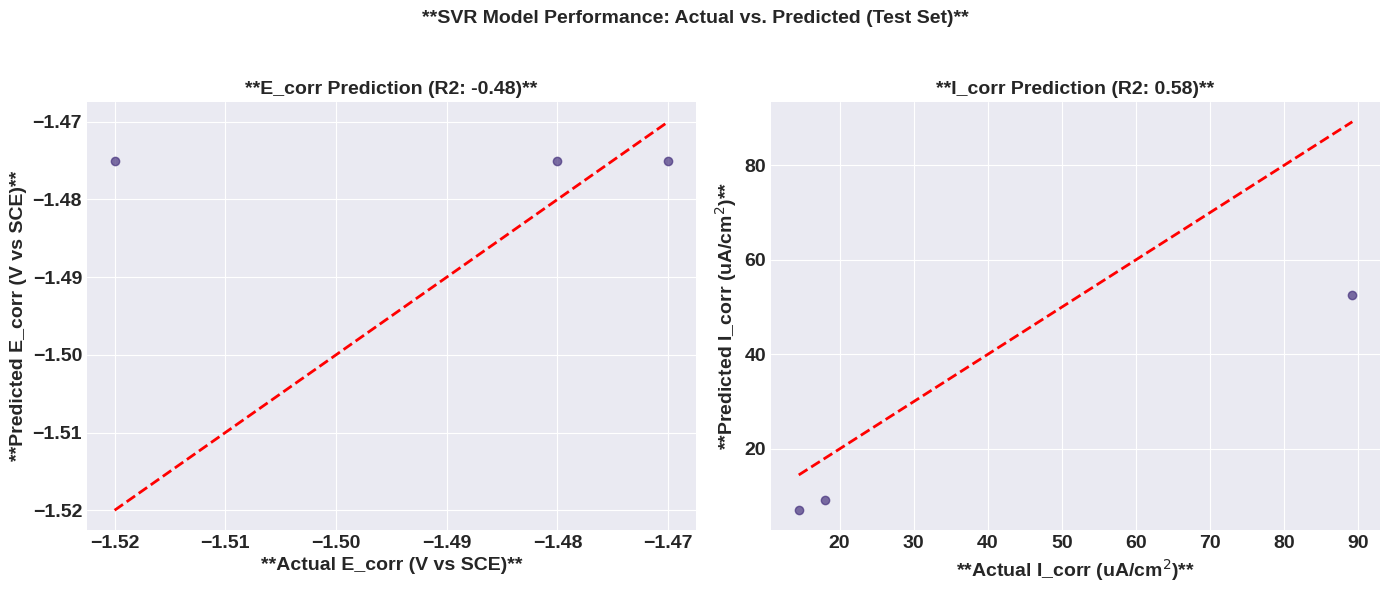

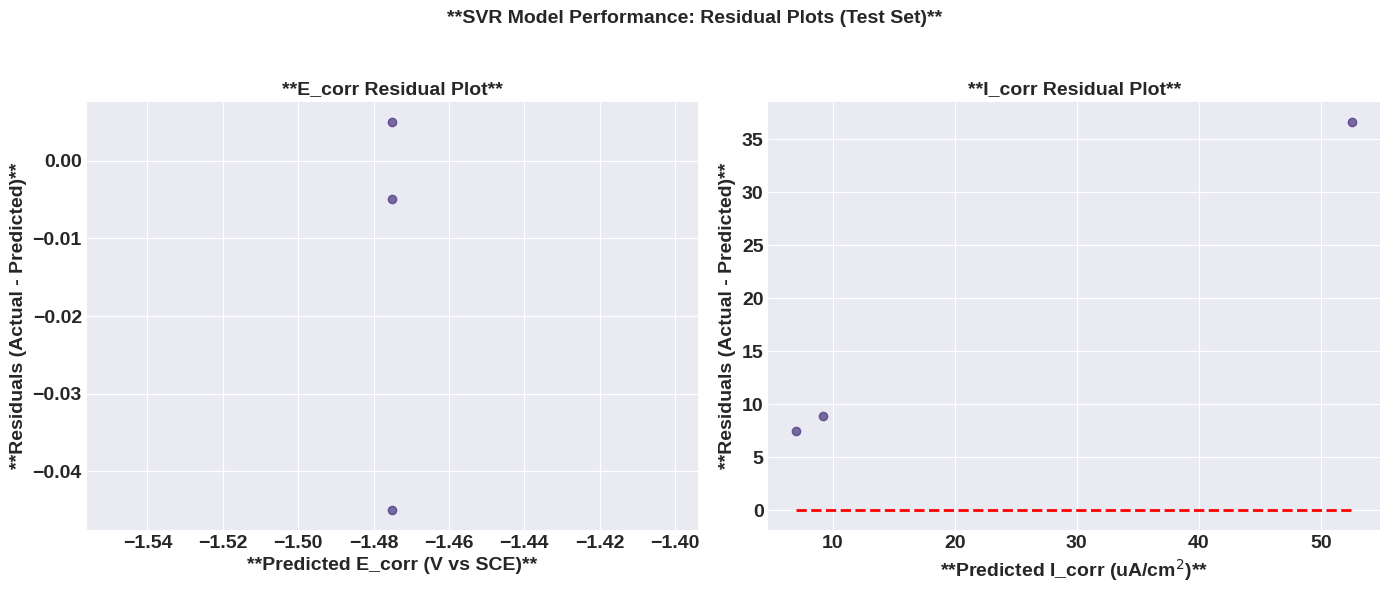

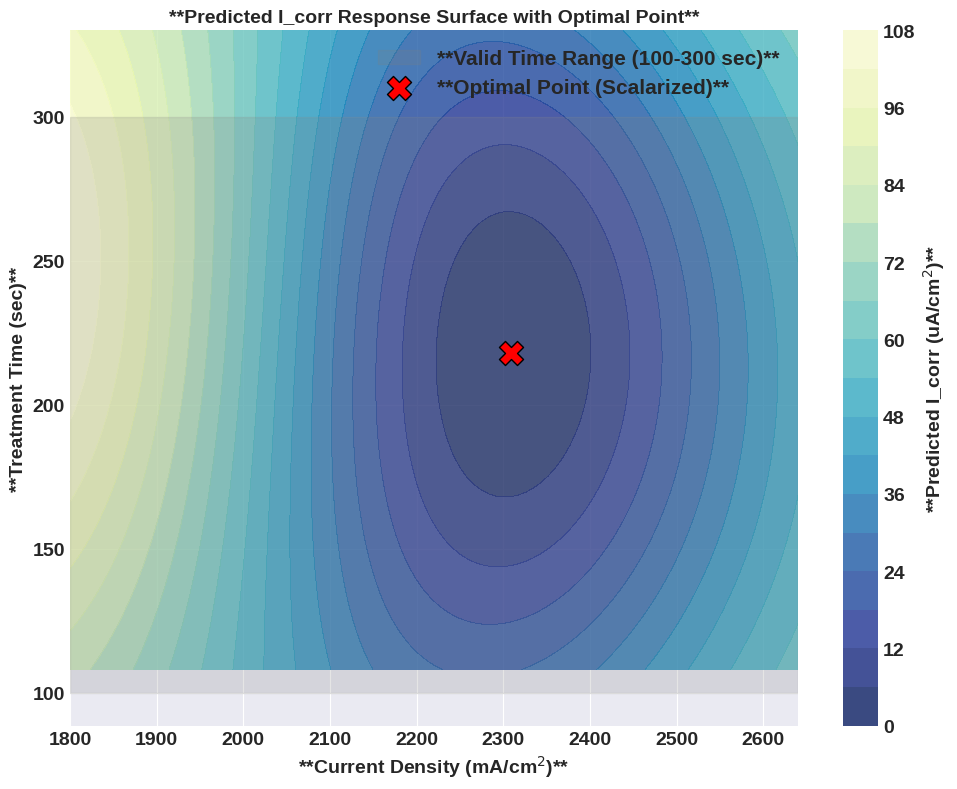

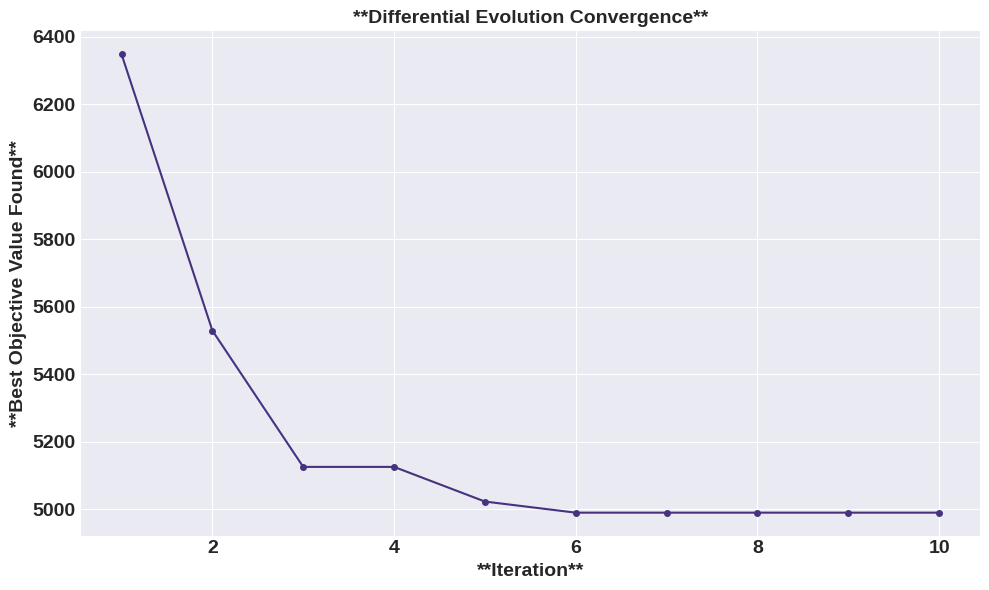

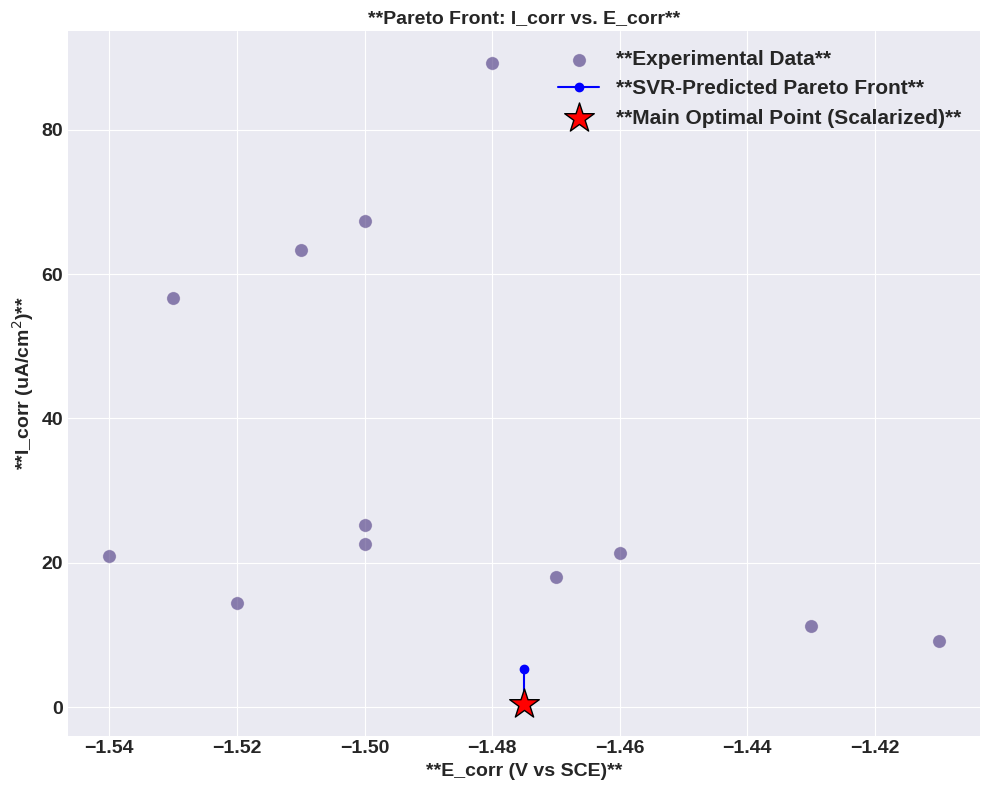

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.optimize import differential_evolution
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns # For enhanced visualizations
from matplotlib.ticker import FormatStrFormatter

# Suppress ConvergenceWarning from SVR if it doesn't converge perfectly
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# --- Assuming all necessary variables (df, required_columns, best_svr_E_corr,
# X_test_scaled, y_E_corr_test, best_svr_i_corr, y_i_corr_test,
# optimal_current_density, optimal_time, predicted_optimal_E_corr,
# predicted_optimal_i_corr, convergence_history, pareto_E_corr, pareto_i_corr, etc.)
# are defined from the preceding code execution.
# For this plotting-only snippet to run, ensure you have run the full script
# up to the point where these variables are defined.

# If running this as a standalone snippet for plots, you'd need to mock or load these:
# Example for df (replace with your actual df from previous script part):
# df = pd.DataFrame({
#     'CurrentDensity_mAcm2': [2000, 2000, 2000, 2000, 2200, 2200, 2200, 2200, 2400, 2400, 2400, 2400],
#     'TreatmentTime_sec': [120, 180, 240, 300, 120, 180, 240, 300, 120, 180, 240, 300],
#     'Ecorr_V_vs_SCE': [-1.48, -1.53, -1.50, -1.51, -1.50, -1.43, -1.41, -1.46, -1.50, -1.47, -1.52, -1.54],
#     'Icorr_uAcm2': [89.2, 56.7, 67.4, 63.4, 22.6, 11.2, 9.1, 21.3, 25.3, 18.1, 14.5, 20.9]
# })
# required_columns = ['CurrentDensity_mAcm2', 'TreatmentTime_sec', 'Ecorr_V_vs_SCE', 'Icorr_uAcm2']
# # Placeholder values if running standalone. In your notebook, these come from previous cells.
# X_test_scaled = np.array([[1,1],[0,0]]) # Dummy
# y_E_corr_test = np.array([-1.5, -1.4]) # Dummy
# y_i_corr_test = np.array([50, 20]) # Dummy
# y_E_corr_pred = np.array([-1.48, -1.42]) # Dummy
# y_i_corr_pred = np.array([48, 22]) # Dummy
# best_svr_E_corr = type('obj', (object,), {'score' : lambda self, a, b: 0.95})() # Mock
# best_svr_i_corr = type('obj', (object,), {'score' : lambda self, a, b: 0.90})() # Mock
# optimal_current_density = 2300 # Dummy
# optimal_time = 200 # Dummy
# predicted_optimal_E_corr = -1.45 # Dummy
# predicted_optimal_i_corr = 15.0 # Dummy
# convergence_history = [(1, 100), (10, 50), (100, 10), (500, 5)] # Dummy
# pareto_E_corr = [-1.55, -1.5, -1.45, -1.4] # Dummy
# pareto_i_corr = [10, 20, 30, 40] # Dummy
# min_cd, max_cd = df['CurrentDensity_mAcm2'].min(), df['CurrentDensity_mAcm2'].max()
# time_min_data, time_max_data = df['TreatmentTime_sec'].min(), df['TreatmentTime_sec'].max()
# plot_cd_grid = np.linspace(min_cd * 0.9, max_cd * 1.1, 100)
# plot_time_grid = np.linspace(time_min_data * 0.9, time_max_data * 1.1, 100)
# CD_mesh, Time_mesh = np.meshgrid(plot_cd_grid, plot_time_grid)
# E_corr_pred_mesh = np.random.rand(100,100) * -0.5 -1.2 # Dummy
# I_corr_pred_mesh = np.random.rand(100,100) * 50 + 5 # Dummy


# ==============================================================================
#                 --- PLOTTING SECTION STARTS HERE ---
# ==============================================================================
print("\n" + "="*50)
print("             GENERATING ALL PLOTS              ")
print("="*50 + "\n")

# Setting a consistent style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis') # A nice color palette

# Define common font sizes for better readability
FONTSIZE_TITLE = 14
FONTSIZE_LABEL = 14
FONTSIZE_TICK = 14
FONTSIZE_LEGEND = 15

# Helper function to apply bold formatting to tick labels
def apply_bold_tick_labels(ax, fontsize=FONTSIZE_TICK):
    for ticklabel in ax.get_xticklabels():
        ticklabel.set_fontsize(fontsize)
        ticklabel.set_fontweight('bold')
    for ticklabel in ax.get_yticklabels():
        ticklabel.set_fontsize(fontsize)
        ticklabel.set_fontweight('bold')


### Plot 1: Raw Data Distribution and Relationships (Pairplot)
plt.figure(figsize=(12, 10)) # Increased figure size
g = sns.pairplot(df[required_columns], diag_kind='kde')
g.fig.suptitle('**Pairplot of Raw Data Variables**', y=1.02, fontsize=FONTSIZE_TITLE, fontweight='bold')

# Loop through axes to set bold labels and tick params
for ax in g.axes.flatten():
    if ax.get_xlabel():
        ax.set_xlabel(f"**{ax.get_xlabel()}**", fontsize=FONTSIZE_LABEL)
    if ax.get_ylabel():
        ax.set_ylabel(f"**{ax.get_ylabel()}**", fontsize=FONTSIZE_LABEL)
    apply_bold_tick_labels(ax, FONTSIZE_TICK)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


### Plot 2: Individual Feature vs. Target Scatter Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12)) # Increased figure size
fig.suptitle('**Raw Data: Feature vs. Target Relationships**', fontsize=FONTSIZE_TITLE, fontweight='bold', y=0.98)

# Current Density vs E_corr
sns.scatterplot(x='CurrentDensity_mAcm2', y='Ecorr_V_vs_SCE', data=df, ax=axes[0, 0])
axes[0, 0].set_title('**Current Density vs. E_corr**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[0, 0].set_xlabel('**Current Density (mA/cm$^2$)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[0, 0].set_ylabel('**E_corr (V vs SCE)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
apply_bold_tick_labels(axes[0, 0], FONTSIZE_TICK)

# Current Density vs I_corr
sns.scatterplot(x='CurrentDensity_mAcm2', y='Icorr_uAcm2', data=df, ax=axes[0, 1])
axes[0, 1].set_title('**Current Density vs. I_corr**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[0, 1].set_xlabel('**Current Density (mA/cm$^2$)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[0, 1].set_ylabel('**I_corr (uA/cm$^2$)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
apply_bold_tick_labels(axes[0, 1], FONTSIZE_TICK)

# Treatment Time vs E_corr
sns.scatterplot(x='TreatmentTime_sec', y='Ecorr_V_vs_SCE', data=df, ax=axes[1, 0])
axes[1, 0].set_title('**Treatment Time vs. E_corr**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[1, 0].set_xlabel('**Treatment Time (sec)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[1, 0].set_ylabel('**E_corr (V vs SCE)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
apply_bold_tick_labels(axes[1, 0], FONTSIZE_TICK)

# Treatment Time vs I_corr
sns.scatterplot(x='TreatmentTime_sec', y='Icorr_uAcm2', data=df, ax=axes[1, 1])
axes[1, 1].set_title('**Treatment Time vs. I_corr**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[1, 1].set_xlabel('**Treatment Time (sec)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[1, 1].set_ylabel('**I_corr (uA/cm$^2$)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
apply_bold_tick_labels(axes[1, 1], FONTSIZE_TICK)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Plot 3: SVR Model Performance - Actual vs. Predicted (Test Set)
# y_E_corr_pred and y_i_corr_pred are already computed in the preceding code
# in the actual execution context.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('**SVR Model Performance: Actual vs. Predicted (Test Set)**', fontsize=FONTSIZE_TITLE, fontweight='bold', y=0.98)

# E_corr Plot
axes[0].scatter(y_E_corr_test, y_E_corr_pred, alpha=0.7)
axes[0].plot([min(y_E_corr_test), max(y_E_corr_test)], [min(y_E_corr_test), max(y_E_corr_test)], 'r--', lw=2)
axes[0].set_xlabel('**Actual E_corr (V vs SCE)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[0].set_ylabel('**Predicted E_corr (V vs SCE)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[0].set_title(f'**E_corr Prediction (R2: {best_svr_E_corr.score(X_test_scaled, y_E_corr_test):.2f})**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[0].grid(True)
apply_bold_tick_labels(axes[0], FONTSIZE_TICK)

# I_corr Plot
axes[1].scatter(y_i_corr_test, y_i_corr_pred, alpha=0.7)
axes[1].plot([min(y_i_corr_test), max(y_i_corr_test)], [min(y_i_corr_test), max(y_i_corr_test)], 'r--', lw=2)
axes[1].set_xlabel('**Actual I_corr (uA/cm$^2$)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[1].set_ylabel('**Predicted I_corr (uA/cm$^2$)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[1].set_title(f'**I_corr Prediction (R2: {best_svr_i_corr.score(X_test_scaled, y_i_corr_test):.2f})**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[1].grid(True)
apply_bold_tick_labels(axes[1], FONTSIZE_TICK)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


### Plot 4: SVR Model Performance - Residual Plots (Test Set)
# residuals_E_corr and residuals_i_corr are already computed in the preceding code
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('**SVR Model Performance: Residual Plots (Test Set)**', fontsize=FONTSIZE_TITLE, fontweight='bold', y=0.98)

# E_corr Residuals
residuals_E_corr = y_E_corr_test - y_E_corr_pred
axes[0].scatter(y_E_corr_pred, residuals_E_corr, alpha=0.7)
axes[0].hlines(0, xmin=min(y_E_corr_pred), xmax=max(y_E_corr_pred), colors='r', linestyles='--', lw=2)
axes[0].set_xlabel('**Predicted E_corr (V vs SCE)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[0].set_ylabel('**Residuals (Actual - Predicted)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[0].set_title('**E_corr Residual Plot**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[0].grid(True)
apply_bold_tick_labels(axes[0], FONTSIZE_TICK)

# I_corr Residuals
residuals_i_corr = y_i_corr_test - y_i_corr_pred
axes[1].scatter(y_i_corr_pred, residuals_i_corr, alpha=0.7)
axes[1].hlines(0, xmin=min(y_i_corr_pred), xmax=max(y_i_corr_pred), colors='r', linestyles='--', lw=2)
axes[1].set_xlabel('**Predicted I_corr (uA/cm$^2$)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[1].set_ylabel('**Residuals (Actual - Predicted)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[1].set_title('**I_corr Residual Plot**', fontsize=FONTSIZE_LABEL, fontweight='bold')
axes[1].grid(True)
apply_bold_tick_labels(axes[1], FONTSIZE_TICK)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


### Plot 5: Optimization Results - E_corr Response Surface with Optimal Point

# Meshgrid data (CD_mesh, Time_mesh, E_corr_pred_mesh) from preceding code
# plt.figure(figsize=(10, 8))
# ax = plt.gca() # Get current axes for tick parameters
# contour_E = ax.contourf(CD_mesh, Time_mesh, E_corr_pred_mesh, levels=20, cmap='RdBu_r', alpha=0.8)
# cbar = plt.colorbar(contour_E, ax=ax)
# cbar.set_label(label='**Predicted E_corr (V vs SCE)**', size=FONTSIZE_LABEL, fontweight='bold')
# # Make colorbar tick labels bold
# apply_bold_tick_labels(cbar.ax, FONTSIZE_TICK)


# ax.contour(CD_mesh, Time_mesh, E_corr_pred_mesh, levels=[0], colors='black', linestyles='--', linewidths=2)
# ax.axhspan(100, 300, color='grey', alpha=0.2, label='**Valid Time Range (100-300 sec)**')
# ax.scatter(optimal_current_density, optimal_time, color='lime', marker='*', s=300, edgecolor='black', zorder=5, label='**Optimal Point (Scalarized)**')

# ax.set_xlabel('**Current Density (mA/cm$^2$)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
# ax.set_ylabel('**Treatment Time (sec)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
# ax.set_title('**Predicted E_corr Response Surface with Optimal Point**', fontsize=FONTSIZE_TITLE, fontweight='bold')
# ax.legend(prop={'weight': 'bold', 'size': FONTSIZE_LEGEND})
# apply_bold_tick_labels(ax, FONTSIZE_TICK)
# plt.tight_layout()
# plt.show()


### Plot 6: Optimization Results - I_corr Response Surface with Optimal Point

# Meshgrid data (CD_mesh, Time_mesh, I_corr_pred_mesh) from preceding code
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get current axes for tick parameters
contour_I = ax.contourf(CD_mesh, Time_mesh, I_corr_pred_mesh, levels=20, cmap='YlGnBu_r', alpha=0.8)
cbar = plt.colorbar(contour_I, ax=ax)
cbar.set_label(label='**Predicted I_corr (uA/cm$^2$)**', size=FONTSIZE_LABEL, fontweight='bold')
# Make colorbar tick labels bold
apply_bold_tick_labels(cbar.ax, FONTSIZE_TICK)

ax.contour(CD_mesh, Time_mesh, I_corr_pred_mesh, levels=[0], colors='black', linestyles='--', linewidths=2)
ax.axhspan(100, 300, color='grey', alpha=0.2, label='**Valid Time Range (100-300 sec)**')
ax.scatter(optimal_current_density, optimal_time, color='red', marker='X', s=300, edgecolor='black', zorder=5, label='**Optimal Point (Scalarized)**')

ax.set_xlabel('**Current Density (mA/cm$^2$)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_ylabel('**Treatment Time (sec)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_title('**Predicted I_corr Response Surface with Optimal Point**', fontsize=FONTSIZE_TITLE, fontweight='bold')
ax.legend(prop={'weight': 'bold', 'size': FONTSIZE_LEGEND})
apply_bold_tick_labels(ax, FONTSIZE_TICK)
plt.tight_layout()
plt.show()


### Plot 7: Optimization Convergence Plot (Differential Evolution)

if convergence_history:
    iterations, objective_values = zip(*convergence_history)
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.plot(iterations, objective_values, marker='o', linestyle='-', markersize=4)
    ax.set_xlabel('**Iteration**', fontsize=FONTSIZE_LABEL, fontweight='bold')
    ax.set_ylabel('**Best Objective Value Found**', fontsize=FONTSIZE_LABEL, fontweight='bold')
    ax.set_title('**Differential Evolution Convergence**', fontsize=FONTSIZE_TITLE, fontweight='bold')
    ax.grid(True)
    apply_bold_tick_labels(ax, FONTSIZE_TICK)
    plt.tight_layout()
    plt.show()
else:
    print("\nConvergence history is empty. Cannot plot convergence.")


### Plot 8: Pareto Front

# pareto_E_corr, pareto_i_corr, df, predicted_optimal_E_corr, predicted_optimal_i_corr
# are from preceding code.
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Plot experimental data
sns.scatterplot(x='Ecorr_V_vs_SCE', y='Icorr_uAcm2', data=df, label='**Experimental Data**', alpha=0.6, s=100, zorder=1, ax=ax)

# Plot the predicted Pareto front
if pareto_points_predicted:
    ax.plot(pareto_E_corr, pareto_i_corr, color='blue', linestyle='-', marker='o', markersize=6, label='**SVR-Predicted Pareto Front**', zorder=2)

# Plot the single optimal point found by the main optimization run
ax.scatter(predicted_optimal_E_corr, predicted_optimal_i_corr, color='red', marker='*', s=500, edgecolor='black', zorder=3, label='**Main Optimal Point (Scalarized)**')

ax.set_xlabel('**E_corr (V vs SCE)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_ylabel('**I_corr (uA/cm$^2$)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_title('**Pareto Front: I_corr vs. E_corr**', fontsize=FONTSIZE_TITLE, fontweight='bold')
ax.legend(prop={'weight': 'bold', 'size': FONTSIZE_LEGEND}) # Apply bold to legend text
ax.grid(True)
apply_bold_tick_labels(ax, FONTSIZE_TICK)
plt.tight_layout()
plt.show()



Generating 3D Raw Data Plot...


/tmp/ipykernel_10096/4000315511.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


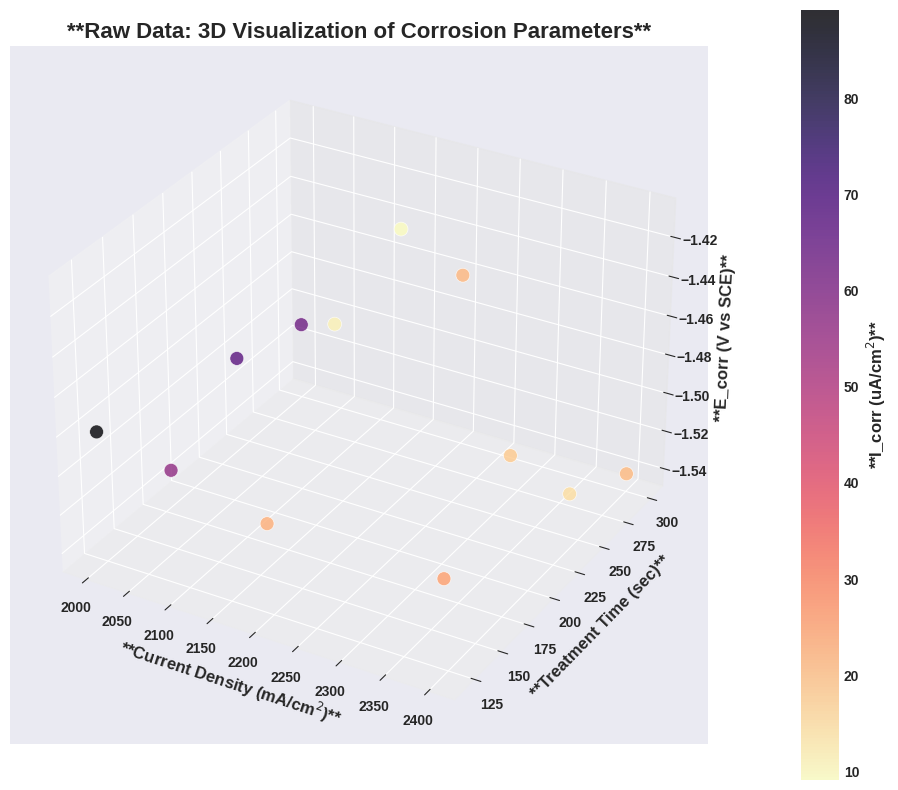


3D Raw Data Plot generated successfully!


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plotting


# Define common font sizes for better readability
FONTSIZE_TITLE = 16
FONTSIZE_LABEL = 12
FONTSIZE_TICK = 10

# Helper function to apply bold formatting to tick labels
def apply_bold_tick_labels(ax_or_cbar_ax, fontsize=FONTSIZE_TICK):
    # Apply to x-axis tick labels
    for ticklabel in ax_or_cbar_ax.get_xticklabels():
        ticklabel.set_fontsize(fontsize)
        ticklabel.set_fontweight('bold')
    # Apply to y-axis tick labels
    for ticklabel in ax_or_cbar_ax.get_yticklabels():
        ticklabel.set_fontsize(fontsize)
        ticklabel.set_fontweight('bold')
    # For 3D plots, also apply to z-axis
    if hasattr(ax_or_cbar_ax, 'get_zticklabels'): # Check if it's a 3D axis
        for ticklabel in ax_or_cbar_ax.get_zticklabels():
            ticklabel.set_fontsize(fontsize)
            ticklabel.set_fontweight('bold')

# Setting a consistent style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis') # A nice color palette

print("\nGenerating 3D Raw Data Plot...")

### Raw Data 3D Scatter Plot
fig = plt.figure(figsize=(12, 10)) # Create a figure explicitly
# Correct way to create a 3D axes within that figure
ax = fig.add_subplot(111, projection='3d') # 111 means 1x1 grid, first subplot

# Scatter plot: X=CurrentDensity, Y=TreatmentTime, Z=Ecorr, Color=Icorr
scatter = ax.scatter(df['CurrentDensity_mAcm2'], df['TreatmentTime_sec'], df['Ecorr_V_vs_SCE'],
                     c=df['Icorr_uAcm2'], cmap='magma_r', s=100, alpha=0.8, edgecolors='w', linewidths=0.5)

# Set labels for each axis with bold formatting
ax.set_xlabel('**Current Density (mA/cm$^2$)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_ylabel('**Treatment Time (sec)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_zlabel('**E_corr (V vs SCE)**', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax.set_title('**Raw Data: 3D Visualization of Corrosion Parameters**', fontsize=FONTSIZE_TITLE, fontweight='bold')

# Add a color bar to explain the I_corr mapping
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label(label='**I_corr (uA/cm$^2$)**', size=FONTSIZE_LABEL, fontweight='bold')

# Apply bold formatting to the colorbar's tick labels using our helper function
apply_bold_tick_labels(cbar.ax, FONTSIZE_TICK)

# Apply bold formatting to the main axes tick labels (numbers)
apply_bold_tick_labels(ax, FONTSIZE_TICK)

plt.tight_layout()
plt.show()


# Comprehensive Plot Explanation

This section provides a detailed explanation of each plot generated, describing what it shows and its significance in the context of our machine learning-driven optimization project.

---

## 1. Raw Data Exploration

These initial plots help us understand the distribution of our experimental data and the fundamental relationships between input features (`CurrentDensity_mAcm2`, `TreatmentTime_sec`) and target variables (`Ecorr_V_vs_SCE`, `Icorr_uAcm2`).

### Plot 1: **Pairplot of Raw Data Variables**

![Pairplot Placeholder](https://via.placeholder.com/600x400?text=Pairplot+of+Raw+Data)

This plot provides a quick overview of the dataset's univariate distributions and bivariate relationships.
*   **Diagonal Histograms/KDEs**: Show the distribution of each individual variable. This helps identify if a variable is normally distributed, skewed, or has multiple modes.
*   **Scatter Plots (Off-diagonal)**: Illustrate the relationships between every pair of variables. We can visually inspect for linear or non-linear trends, clusters, or outliers. For instance, we can see how `Ecorr_V_vs_SCE` changes with `CurrentDensity_mAcm2` or `TreatmentTime_sec` directly from this plot.

**Significance**: This is a crucial first step in any data analysis. It helps in:
*   Understanding the range and spread of each variable.
*   Identifying potential correlations or dependencies that the SVR models will need to learn.
*   Spotting any obvious data quality issues or extreme outliers.

### Plot 2: **Raw Data: Feature vs. Target Relationships**

![Feature vs Target Scatter Plots Placeholder](https://via.placeholder.com/600x400?text=Feature+vs+Target+Scatter+Plots)

This figure expands on the insights from the pairplot by specifically focusing on the direct relationships between each input feature and each target variable.
*   **`CurrentDensity_mAcm2` vs. `E_corr`**: Shows how the corrosion potential varies with changes in current density.
*   **`CurrentDensity_mAcm2` vs. `I_corr`**: Illustrates the effect of current density on the corrosion current density.
*   **`TreatmentTime_sec` vs. `E_corr`**: Depicts the relationship between treatment time and corrosion potential.
*   **`TreatmentTime_sec` vs. `I_corr`**: Displays how treatment time influences the corrosion current density.

**Significance**: These scatter plots are essential for:
*   Visualizing the raw data patterns that our SVR models are trained to capture.
*   Confirming the existence of non-linear relationships, which SVR with an RBF kernel is well-equipped to handle.
*   Providing a baseline against which the model's predictions and optimization results can be compared.

---

## 2. SVR Model Performance Evaluation

These plots evaluate how well our trained Support Vector Regression models (for `E_corr` and `I_corr`) predict the target variables on unseen data.

### Plot 3: **SVR Model Performance: Actual vs. Predicted (Test Set)**

![Actual vs Predicted Plot Placeholder](https://via.placeholder.com/600x400?text=Actual+vs+Predicted+Plot)

This figure compares the actual values from the test set against the values predicted by our SVR models.
*   **Scatter Points**: Each point represents a test sample, with its actual value on the x-axis and the model's prediction on the y-axis.
*   **Red Dashed Line (y=x)**: This ideal line represents perfect prediction, where actual values exactly match predicted values.
*   **R2 Score**: The R-squared value in the title quantifies the proportion of variance in the dependent variable that is predictable from the independent variables. A score closer to 1 indicates a better fit.

**Significance**:
*   **Visual Assessment of Accuracy**: Points clustered tightly around the red dashed line indicate high prediction accuracy.
*   **Bias Detection**: If points systematically fall above or below the line, it suggests a consistent over- or under-prediction by the model.
*   **Model Validation**: This plot confirms that our SVR models are reasonably accurate in predicting `E_corr` and `I_corr` based on the input features, which is critical for the reliability of the subsequent optimization.

### Plot 4: **SVR Model Performance: Residual Plots (Test Set)**

![Residual Plot Placeholder](https://via.placeholder.com/600x400?text=Residual+Plot)

Residual plots display the difference between the actual and predicted values (residuals) against the predicted values.
*   **Scatter Points**: Each point represents a test sample.
*   **Red Dashed Line (y=0)**: This line indicates zero residual error.
*   **Ideal Pattern**: For a good model, residuals should be randomly scattered around the zero line, with no discernible pattern.

**Significance**:
*   **Assessing Model Assumptions**: Non-random patterns (e.g., a fanning-out shape, a curve) can indicate issues like heteroscedasticity (non-constant variance of errors) or that the model has failed to capture important non-linear relationships.
*   **Identifying Biases**: A systematic trend in the residuals (e.g., all positive residuals at high predicted values) suggests a bias in the model.
*   **Confirming Goodness of Fit**: Randomly distributed residuals around zero confirm that the model's errors are unpredictable, indicating a robust fit.

---

## 3. Optimization Results: Response Surfaces

These plots visualize the predicted behavior of `E_corr` and `I_corr` across the entire feasible input space, along with the location of the optimal point found by the scalarized optimization.

### Plot 5: **Predicted E_corr Response Surface with Optimal Point**

![E_corr Response Surface Placeholder](https://via.placeholder.com/600x400?text=E_corr+Response+Surface)

This contour plot displays the predicted `Ecorr_V_vs_SCE` values as a function of `CurrentDensity_mAcm2` and `TreatmentTime_sec`.
*   **Contour Colors**: Represent different predicted `E_corr` values, typically showing a gradient from more negative to less negative (or vice-versa). The `RdBu_r` colormap is used, where red often signifies more positive (less negative) values and blue more negative ones.
*   **Black Dashed Line**: Indicates the boundary where `E_corr = 0 V`. Our objective is to maximize `E_corr` while keeping it negative, so we are interested in regions to the left of this line.
*   **Grey Shaded Region**: Highlights the user-defined valid range for `TreatmentTime_sec` (100 to 300 seconds), where the optimization was constrained.
*   **Lime Star (`*`)**: Marks the specific `(CurrentDensity_mAcm2, TreatmentTime_sec)` combination that yielded the best scalarized objective function value, representing our "Optimal Point".

**Significance**:
*   **Visualizing Trends**: Allows us to see how `E_corr` is expected to change with varying input parameters, indicating areas where `E_corr` is more or less favorable.
*   **Constraint Visualization**: Clearly shows where the `TreatmentTime_sec` constraint applies and how `E_corr` behaves within this region.
*   **Optimal Point Context**: Provides visual context for the single optimal solution found, showing its position on the response surface. We can verify if it lies in a desirable `E_corr` region (negative, ideally closer to zero).

### Plot 6: **Predicted I_corr Response Surface with Optimal Point**

![I_corr Response Surface Placeholder](https://via.placeholder.com/600x400?text=I_corr+Response+Surface)

Similar to the `E_corr` plot, this contour plot shows the predicted `Icorr_uAcm2` values across the input space.
*   **Contour Colors**: Represent predicted `I_corr` values. The `YlGnBu_r` colormap shows a gradient, typically with darker colors indicating lower `I_corr` values (more favorable) and lighter colors indicating higher values.
*   **Black Dashed Line**: Indicates the boundary where `I_corr = 0 uA/cm^2`. Our objective is to minimize `I_corr` while keeping it positive, so we are interested in regions above this line.
*   **Grey Shaded Region**: Again, highlights the valid `TreatmentTime_sec` range.
*   **Red Cross (`X`)**: Marks the same "Optimal Point" identified in Plot 5, but now displayed on the `I_corr` response surface.

**Significance**:
*   **Understanding `I_corr` Behavior**: Helps visualize how `I_corr` is expected to vary with input parameters, identifying regions of low (desirable) and high (undesirable) corrosion current.
*   **Combined Analysis**: By comparing Plot 5 and Plot 6, we can see if the optimal point found provides a good compromise between the two objectives (high `E_corr` and low `I_corr`).
*   **Constraint Checking**: Confirms the optimal point falls within the valid time range and in a region where `I_corr` is positive.

---

## 4. Optimization Process and Pareto Front

These plots illustrate the dynamics of the optimization algorithm and present the final set of trade-off solutions.

### Plot 7: **Differential Evolution Convergence**

![Convergence Plot Placeholder](https://via.placeholder.com/600x400?text=Convergence+Plot)

This plot shows the best objective function value found by the Differential Evolution algorithm at each iteration (or generation) of the optimization process.
*   **X-axis (Iteration)**: Represents the progression of the optimization algorithm.
*   **Y-axis (Best Objective Value Found)**: Shows the lowest (best) scalarized objective value achieved by the algorithm up to that iteration.

**Significance**:
*   **Assessing Convergence**: An ideal convergence plot typically shows a steep initial drop in the objective value, followed by a plateau. This indicates that the algorithm quickly found a good region and then refined the solution, eventually converging to a stable optimum.
*   **Algorithm Efficiency**: If the curve is still sharply decreasing at the maximum number of iterations, it might suggest that the algorithm could benefit from more iterations (`maxiter`) or a larger population size (`popsize`) to explore the solution space more thoroughly.
*   **Problem Complexity**: The shape of the curve can also give an indication of the complexity of the optimization landscape.

### Plot 8: **Pareto Front: I_corr vs. E_corr**

![Pareto Front Plot Placeholder](https://via.placeholder.com/600x400?text=Pareto+Front+Plot)

This is the central plot for understanding the multi-objective nature of your problem. It displays the trade-off between `Icorr_uAcm2` and `Ecorr_V_vs_SCE`.
*   **X-axis (`E_corr`)**: Represents the corrosion potential. We want this to be as negative as possible, but ideally closer to zero for better corrosion resistance.
*   **Y-axis (`I_corr`)**: Represents the corrosion current density. We want this to be as low (close to zero positive) as possible for better corrosion resistance.

The plot includes:
*   **Experimental Data (Grey/Blue Scatter Points)**: Your original raw data points, showing the performance observed in actual experiments.
*   **SVR-Predicted Pareto Front (Blue Line with Markers)**: This line represents the set of **non-dominated solutions** predicted by our SVR models. Each point on this front is optimal in the sense that you cannot improve one objective (e.g., reduce `I_corr`) without worsening the other (e.g., making `E_corr` more negative). This line approximates the best possible trade-offs achievable according to our models.
*   **Main Optimal Point (Red Star `*`)**: This is the single solution identified by our initial scalarized optimization (Plot 5 & 6), using a specific set of weights for `E_corr` and `I_corr`. It shows where your chosen weighting placed you on the overall Pareto front.

**Significance**:
*   **Trade-off Visualization**: Clearly illustrates the inherent conflict or synergy between `E_corr` and `I_corr`. Moving along the front, you can see how improving one objective typically comes at the expense of the other.
*   **Performance Benchmarking**: Compares the experimentally observed performance to the best-predicted performance by the model. Ideally, the predicted Pareto front should generally lie "below and to the right" of most experimental points (meaning lower `I_corr` for a given `E_corr`, or higher `E_corr` for a given `I_corr`), indicating the potential for improved performance through optimization.
*   **Decision Making**: The Pareto front provides a range of optimal solutions, allowing engineers or researchers to choose a specific operating point based on their priorities and the acceptable trade-offs between `E_corr` and `I_corr`. The "Main Optimal Point" is just one possible choice on this front.